# Motion Estimation

Шаблон для выполнения задания состоит из нескольких частей

1. Библиотека ME на C/C++, компилируемая для использования в python-коде. В основном писать код вам придётся именно в библиотеке. Чтобы скомпилировать библиотеку, запустите команду `python3 setup.py build_ext -i` в  корне папки с заданием. *Замечание. Это библиотека компилируется под C++, но внутри вам ничего не мешает писать код на чистом C.*
2. Ipython notebook для тестирования библиотеки. Используйте этот код для оценки качества работы программы и её улучшения.

### 1. Основная часть ###

Оценка качества работы алгоритма будет производиться следующим образом: на основе поля ME между двумя кадрами будет построен восстановленный кадр. Для оценивания качества будет использоваться PSNR между восстановленным и исходным кадром:

<img src="images/me_example.png">

<img src="images/how_it_works.png">

In [18]:
# Импортируем нужные библиотеки
import cv2
import time
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import importlib
%matplotlib inline

In [19]:
#Библиотека для чтения видео
class VideoReader:
    def __init__(self, path):
        self.cap = cv2.VideoCapture(path)
        self.height = int(self.cap.get(4))
        self.width = int(self.cap.get(3))
    
    def __iter__(self):
        while(self.cap.isOpened()):
            ret, frame = self.cap.read()
            if ret == False:
                break
            yield frame
    
    def height(self):
        return self.heigth
    
    def width(self):
        return self.width
    
    def __del__(self):
        self.cap.release()

def generate_pair_frames_gray(video):
    prev_frame = None
    for frame in video:
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        if prev_frame is None:
            prev_frame = frame
        else:
            yield prev_frame, frame
            prev_frame = frame

In [20]:

def show_pair_frames(compensated_frame, frame, psnr_value):
    fig = plt.figure(figsize=(16,7))
    plt.suptitle('Значение PSNR: {:.4f}'.format(psnr_value), fontsize=24)
    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(compensated_frame, cmap='gray')
    ax.set_title("Скомпенсированный кадр", fontsize=18)
    ax.set_xticks([])
    ax.set_yticks([])
    ax = fig.add_subplot(1, 2, 2)
    ax.imshow(frame, cmap='gray')
    ax.set_title("Текущий кадр", fontsize=18)
    ax.set_xticks([])
    ax.set_yticks([])

In [21]:
def test_me(source_video, me, return_frames=False, result_path=None):
    ssim = []
    psnr = []
    speed = []
    compensated_frames = []
    source_frames = []
    out_video = None
    if result_path is not None:
        out_video = cv2.VideoWriter(
            result_path,
            cv2.VideoWriter_fourcc(*'MP4V'),
            10,
            (source_video.width, source_video.height * 2)
        )
     
    pbar = tqdm(generate_pair_frames_gray(source_video))
    for frame, prev_frame in pbar:
        start = time.time()
        result = me.Estimate(frame, prev_frame) # Запускаем me
        end = time.time()
        speed.append((end - start) * 1000)
        compensated_frame = result.Remap(prev_frame) # Скомпенсированный кадр лежит тут. Полезно для дебага его отсюда доставать и рассматривать.
        
        ssim.append(structural_similarity(frame, compensated_frame, multichannel=False))
        psnr.append(peak_signal_noise_ratio(frame, compensated_frame))
        if return_frames:
            compensated_frames.append(compensated_frame)
            source_frames.append(frame)
        
        
        pbar.set_description('PSNR: {:.2f}; Time(ms): {:.2f}; SSIM: {:.2f}.'.format(np.mean(psnr), np.mean(speed), np.mean(ssim)))
       # k+=1
        if out_video is not None:
            out_video.write(cv2.cvtColor(np.vstack([frame, compensated_frame]), cv2.COLOR_GRAY2BGR))
    if out_video is not None:
        out_video.release()
        
    return {
        'ssim': ssim,
        'psnr': psnr,
        'speed': speed,
        'compensated_frames': compensated_frames,
        'source_frames': source_frames
    }

## Ваше решение

In [22]:
class MotionEstimator:
    def __init__(self, width, height, quality, halfpixel):
        import me_estimator
        
        self.width = width
        self.height = height
        self.quality = quality
        self.halfpixel = halfpixel

        self.me = me_estimator.MotionEstimator(self.width, self.height, self.quality, self.halfpixel)

    def Estimate(self, frame, prev_frame):
        return self.me.Estimate(frame, prev_frame)


Чтобы проверить, как работет библиотека, давайте проверим его на одной последовательности на самом хорошем качестве.  
*То, что Ваше ME будет по качеству работать хуже полного перебора - это норма. Ваша задача - достаточно сильно ускорить ME, он должен работать ориентировочно за 5-10 мс на кадр. Ориентировочная точка - одно из самых лучших решений прошлого года на среднем ноутбуке показало **5.06ms и 35.1 psnr** на качестве 100.*

In [23]:
video = VideoReader('video/source.avi')
print(video.width,video.height)
me = MotionEstimator(video.width, video.height,100, False)
result = test_me(video, me, True, 'result_2.mp4') # В result.mp4 сохраняем скомпенсированное видео, также в result будут лежать кадры

352 288


Посмотрим на то, как компенсируется произвольный кадр:

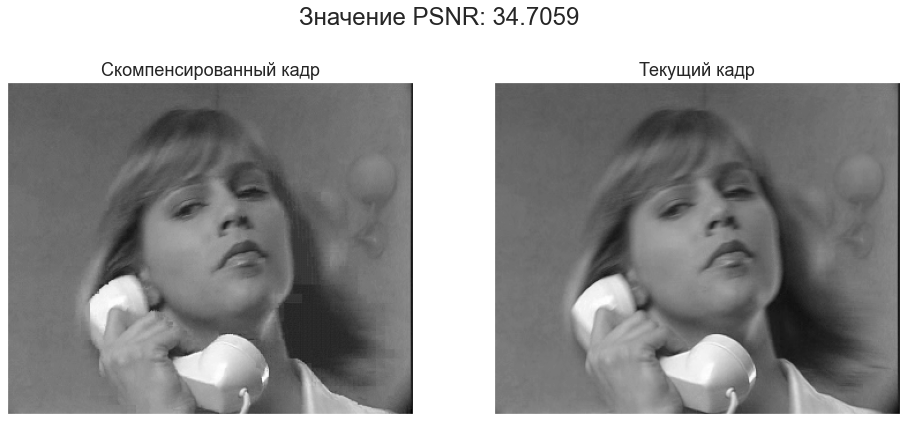

In [24]:
frame_idx = 30
show_pair_frames(
    result['compensated_frames'][frame_idx],
    result['source_frames'][frame_idx],
    result['psnr'][frame_idx]
)

Примером ниже можно посмотреть графики, как покадрово работает ваш алгоритм. 

<Figure size 864x432 with 0 Axes>

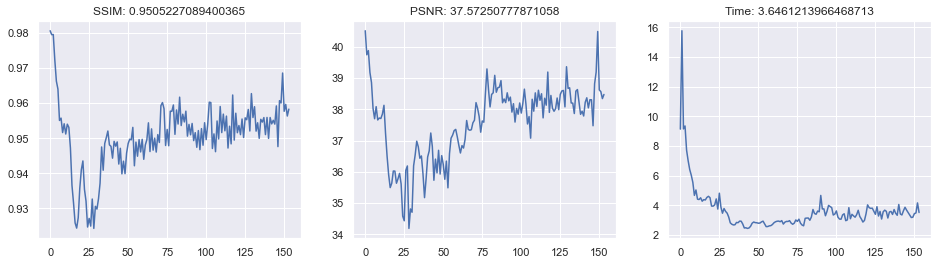

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set("notebook")
plt.figure(figsize=(12, 6))
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))

ax1.plot(result['ssim'])
ax1.set_title('SSIM: {}'.format(np.mean(result['ssim'])))
ax2.plot(result['psnr'])
ax2.set_title('PSNR: {}'.format(np.mean(result['psnr'])))
ax3.plot(result['speed'])
ax3.set_title('Time: {}'.format(np.mean(result['speed'])));

In [26]:
import pandas as pd

def test_all_me(video_paths=['drop.avi'], qualities=[100, 80, 60, 40, 20], halfpixels=[False, True]):
    result = []
    for video_path in video_paths:
        for halfpixel in halfpixels:
            for quality in qualities:
                video = VideoReader(video_path)
                me = MotionEstimator(video.width, video.height, quality, halfpixel)
                metrics = test_me(video, me)
                result.append(
                    {
                        'video': video_path,
                        'halfpixel': halfpixel,
                        'quality': quality,
                        **{
                            key: np.mean(metrics[key])
                            for key in metrics
                        }
                    }
                )
    return pd.DataFrame(result)

In [27]:
result_all = test_all_me(
    video_paths=['video/source.avi'],
    qualities=[100,80,60, 40, 20],
    halfpixels=[False, True]
)

/Users/maxim/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/maxim/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [28]:
result_all

,video,halfpixel,quality,ssim,psnr,speed,compensated_frames,source_frames
0,video/source.avi,False,100,0.950523,37.572508,3.668677,NaN,NaN
1,video/source.avi,False,80,0.945000,36.905163,2.259567,NaN,NaN
2,video/source.avi,False,60,0.941141,36.469176,1.288889,NaN,NaN
3,video/source.avi,False,40,0.937657,36.019630,0.750964,NaN,NaN
4,video/source.avi,False,20,0.934205,35.497220,0.496694,NaN,NaN
5,video/source.avi,True,100,0.955322,37.885042,4.489687,NaN,NaN
6,video/source.avi,True,80,0.950423,37.187711,2.980090,NaN,NaN
7,video/source.avi,True,60,0.947172,36.889363,1.856519,NaN,NaN
8,video/source.avi,True,40,0.943520,36.451186,1.300891,NaN,NaN
9,video/source.avi,True,20,0.939912,35.907758,1.008960,NaN,NaN


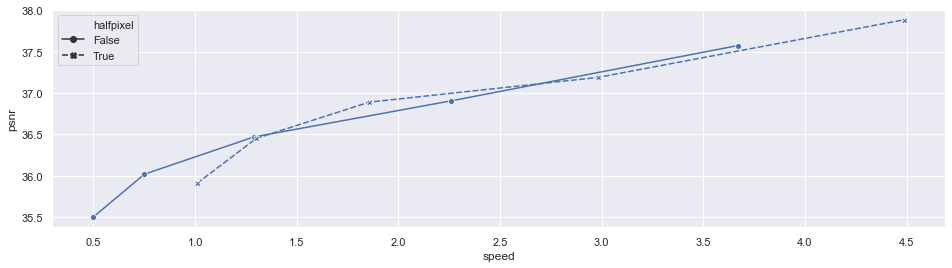

In [29]:
fig, axes =plt.subplots(1, len(result_all['video'].unique()), figsize=(16, 4))
if len(result_all['video'].unique()) == 1:
    axes = [axes]
for ax, video in zip(axes, result_all['video'].unique()):
    sns.lineplot(x='speed', y='psnr', style='halfpixel', markers=True, data=result_all[result_all.video == video], ax=ax)